In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Create the maze environment
maze = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])
MAZE_SIZE = maze.shape[0]

# Start, sub-goal, and end goal positions
start_position = (1, 1)
sub_goal_position = (5, 3)
end_goal_position = (7, 8)

# Actions the agent can take: Up, Down, Left, Right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]


In [55]:
gamma = 0.8         # Discount factor
alpha_actor = 0.8 # Actor learning rate
alpha_critic = 0.4 # Critic learning rate
epsilon = 0.5       # Exploration rate
episodes = 2000     # Number of episodes
max_steps = 200     # Max steps per episode

# Initialize value function (critic) and policy (actor)
V = np.zeros((MAZE_SIZE, MAZE_SIZE, 2))  # State-value function
policy = np.ones((MAZE_SIZE, MAZE_SIZE, len(actions))) / len(actions)  # Initial uniform policy

# Reward matrix setup
reward_matrix = np.full(maze.shape, -1.0)  # Negative reward for each step
reward_matrix[sub_goal_position] = 10.0    # Reward for reaching sub-goal
reward_matrix[end_goal_position] = 500.0   # Reward for reaching end goal

# Variables to track evaluation metrics
success_count = 0
total_rewards = 0
total_steps_to_sub_goal = 0
total_steps_to_end_goal = 0
successful_episodes = 0
learning_rates = []
convergence_episodes = []

# Arrays to track learning curve
rewards_per_episode = []
success_rate_per_episode = []

# Function to choose the next action using epsilon-greedy policy
def epsilon_greedy(state):
    if np.random.rand() < epsilon:
        return np.random.randint(len(actions))  # Explore
    else:
        return np.argmax(policy[state[0], state[1]])  # Exploit

# Function to run Actor-Critic learning
def actor_critic():
    global success_count, total_rewards, total_steps_to_sub_goal, total_steps_to_end_goal, successful_episodes
    
    for episode in range(episodes):
        state = (start_position[0], start_position[1], False)
        visited_states = set()
        episode_reward = 0
        steps_taken = 0
        sub_goal_steps = 0
        
        subgoal_reached = False

        for step in range(max_steps):
            action_idx = epsilon_greedy(state)
            action = actions[action_idx]
            next_x = state[0] + action[0]
            next_y = state[1] + action[1]
            
            # Check if next_state is within bounds and not a wall
            if 0 <= next_x < MAZE_SIZE and 0 <= next_y < MAZE_SIZE and maze[next_x, next_y] == 0:
                
                # Prevent going back to previous states if subgoal is reached
                if subgoal_reached and (next_x, next_y) in visited_states:
                    reward = -100
                else:
                    visited_states.add((next_x, next_y))
                    reward = reward_matrix[next_x, next_y]
                    episode_reward += reward

                    # If sub-goal is reached
                    if (next_x, next_y) == sub_goal_position and not subgoal_reached:
                        subgoal_reached = True
                        reward = 10.0
                        sub_goal_steps = steps_taken + 1
                        total_steps_to_sub_goal += sub_goal_steps

                    # If end goal is reached
                    if (next_x, next_y) == end_goal_position:
                        if subgoal_reached:
                            reward = 500.0
                            success_count += 1
                            successful_episodes += 1
                            total_steps_to_end_goal += steps_taken + 1
                            convergence_episodes.append(episode)
                            break
                        else:
                            reward = -100.0   # Penalty for trying to reach end goal before sub-goal

                # Actor-Critic update rule
                best_next_action = np.argmax(policy[next_x, next_y])
                td_target = reward + gamma * V[next_x, next_y, int(subgoal_reached)]
                td_delta = td_target - V[state[0], state[1], int(subgoal_reached)]
                
                # Update value function (critic)
                V[state[0], state[1], int(subgoal_reached)] += alpha_critic * td_delta
                
                # Update policy (actor)
                policy[state[0], state[1], action_idx] += alpha_actor * td_delta
                policy[state[0], state[1]] /= np.sum(policy[state[0], state[1]])  # Normalize policy
                
                state = (next_x, next_y, subgoal_reached)
                steps_taken += 1
                
                # End episode if end goal is reached after sub-goal
                if (next_x, next_y) == end_goal_position and subgoal_reached:
                    break
            else:
                # Penalize hitting a wall or moving out of bounds
                V[state[0], state[1], int(subgoal_reached)] += alpha_critic * (-100 + gamma * 0 - V[state[0], state[1], int(subgoal_reached)])
                
        total_rewards += episode_reward
        rewards_per_episode.append(episode_reward)
        success_rate_per_episode.append(success_count / (episode + 1))
        if (episode + 1) % 100 == 0:
            print(f'Episode {episode + 1}/{episodes} completed.')

actor_critic()  # Calculate evaluation metrics


Episode 100/2000 completed.
Episode 200/2000 completed.
Episode 300/2000 completed.
Episode 400/2000 completed.
Episode 500/2000 completed.
Episode 600/2000 completed.
Episode 700/2000 completed.
Episode 800/2000 completed.
Episode 900/2000 completed.
Episode 1000/2000 completed.
Episode 1100/2000 completed.
Episode 1200/2000 completed.
Episode 1300/2000 completed.
Episode 1400/2000 completed.
Episode 1500/2000 completed.
Episode 1600/2000 completed.
Episode 1700/2000 completed.
Episode 1800/2000 completed.
Episode 1900/2000 completed.
Episode 2000/2000 completed.


In [56]:
success_rate = success_count / episodes
average_reward = total_rewards / episodes
average_steps_to_sub_goal = total_steps_to_sub_goal / successful_episodes if successful_episodes > 0 else 0
average_steps_to_end_goal = total_steps_to_end_goal / successful_episodes if successful_episodes > 0 else 0
average_convergence_speed = np.mean(convergence_episodes) if convergence_episodes else 0
average_learning_rate = np.mean(learning_rates)

# Print evaluation results
print(f'Success Rate: {success_rate * 100:.2f}%')
print(f'Average Reward: {average_reward:.2f}')
print(f'Average Steps to Sub-Goal: {average_steps_to_sub_goal:.2f}')
print(f'Average Steps to End-Goal: {average_steps_to_end_goal:.2f}')
print(f'Average Convergence Speed: {average_convergence_speed:.2f}')
print(f'Average Learning Rate: {average_learning_rate:.6f}')


Success Rate: 14.20%
Average Reward: 262.11
Average Steps to Sub-Goal: 190.04
Average Steps to End-Goal: 76.40
Average Convergence Speed: 961.00
Average Learning Rate: nan


c:\Users\erine\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\erine\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [57]:

# Function to extract the optimal path from start to goal
def extract_ac_path(start, goal):
    state = (start[0], start[1], False)
    path = [state[:2]]
    
    for step in range(max_steps):
        action_idx = np.argmax(policy[state[0], state[1]])
        action = actions[action_idx]
        next_x = state[0] + action[0]
        next_y = state[1] + action[1]
        subgoal_reached = state[2]
        
        if 0 <= next_x < MAZE_SIZE and 0 <= next_y < MAZE_SIZE and maze[next_x, next_y] == 0:
            if (next_x, next_y) == sub_goal_position:
                subgoal_reached = True
            state = (next_x, next_y, subgoal_reached)
            path.append((next_x, next_y))
        else:
            break  # Invalid move, stop the path
        
        if (next_x, next_y) == goal and subgoal_reached:
            break
    
    return path

# Get the optimal path from start to end goal
optimal_path = extract_ac_path(start_position, end_goal_position)
print("Optimal Path:", optimal_path)

Optimal Path: [(1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (4, 3), (5, 3), (5, 4), (5, 5), (5, 6), (6, 6), (6, 7), (6, 8), (7, 8)]


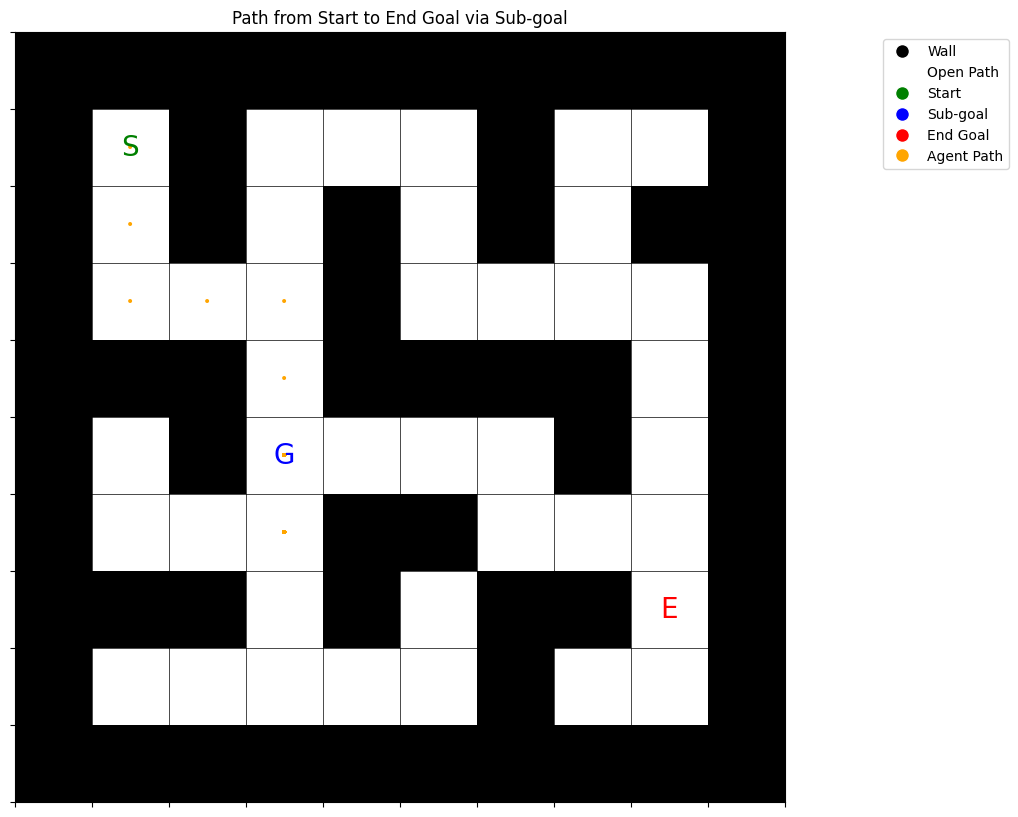

In [58]:

# Function to visualize the agent's path
def visualize_path(path, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap="gray_r")
    for (x, y) in path:
        plt.text(y, x, '•', color='orange', ha='center', va='center', fontsize=10)
    plt.text(start_position[1], start_position[0], 'S', color='green', ha='center', va='center', fontsize=20)
    plt.text(sub_goal_position[1], sub_goal_position[0], 'G', color='blue', ha='center', va='center', fontsize=20)
    plt.text(end_goal_position[1], end_goal_position[0], 'E', color='red', ha='center', va='center', fontsize=20)
    plt.title(title)
    plt.grid(True, which='both', color='black', linewidth=0.5)
    plt.xticks(np.arange(-.5, MAZE_SIZE, 1), [])
    plt.yticks(np.arange(-.5, MAZE_SIZE, 1), [])
    
    # Legend/map for a better visualization
    labels = ['Wall', 'Open Path', 'Start', 'Sub-goal', 'End Goal', 'Agent Path']
    colors = ['black', 'white', 'green', 'blue', 'red', 'orange']
    patches = []

    # Loop through each label and color to create legend symbols
    for i in range(len(labels)):
        label = labels[i]
        color = colors[i]
        
        # Create legend symbols using a small circle marker with the label and color
        patch = plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
        patches.append(patch)

    plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.3, 1))
    
    plt.show()

visualize_path(optimal_path, "Path from Start to End Goal via Sub-goal")

steps_to_sub_goal = optimal_path.index(sub_goal_position) + 1 if sub_goal_position in optimal_path else None
steps_to_end_goal = len(optimal_path)




Success Rate: 100.00%
Average Reward: 500.00
Average Steps to Sub-Goal: 7.00
Average Steps to End Goal: 14.00
Average Convergence Speed: 47.00


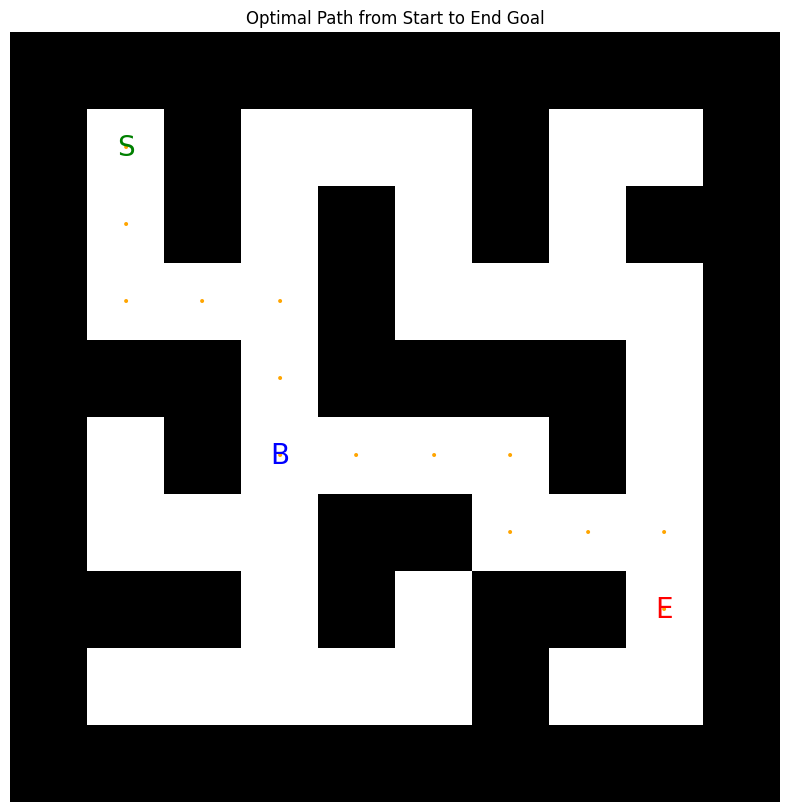

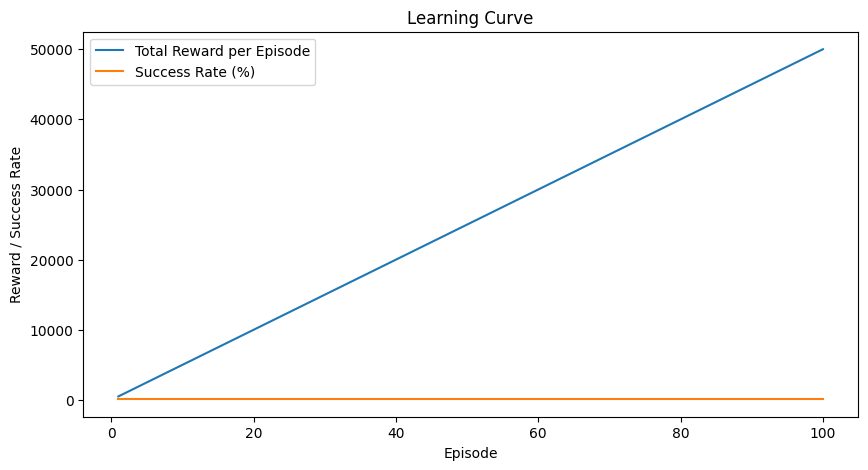

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Create the maze environment
maze = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

MAZE_SIZE = maze.shape[0]

# Start, sub-goal, and end goal positions
start_position = (1, 1)
sub_goal_position = (5, 3)
end_goal_position = (7, 8)

# Actions the agent can take: Up, Down, Left, Right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
gamma = 0.8         # Discount factor
theta = 1e-5        # Convergence threshold

# Initialize value function
value_function = np.zeros(maze.shape)

# Reward matrix
reward_matrix = np.full(maze.shape, -1.0)  # Negative reward for each step
reward_matrix[sub_goal_position] = 10.0    # Reward for reaching sub-goal
reward_matrix[end_goal_position] = 500.0   # Reward for reaching end goal

def is_valid_move(x, y):
    """Check if the position is within the maze and is an open path."""
    return 0 <= x < MAZE_SIZE and 0 <= y < MAZE_SIZE and maze[x, y] == 0

def value_iteration():
    """Perform value iteration to compute the value function."""
    global value_function
    convergence_iterations = 0  # Initialize convergence iteration count
    
    while True:
        delta = 0  # Initialize maximum change in value function
        convergence_iterations += 1  # Increment iteration count
        
        for x in range(MAZE_SIZE):
            for y in range(MAZE_SIZE):
                if maze[x, y] == 0:  # Only consider open cells
                    v = value_function[x, y]  # Store current value
                    action_values = []

                    for action in actions:
                        next_x, next_y = x + action[0], action[1]
                        if is_valid_move(next_x, next_y):
                            action_value = reward_matrix[next_x, next_y] + gamma * value_function[next_x, next_y]
                        else:
                            action_value = -100.0  # Penalty for hitting a wall or going out of bounds
                        action_values.append(action_value)

                    # Update value function
                    value_function[x, y] = max(action_values)
                    # Update delta for convergence check
                    delta = max(delta, abs(v - value_function[x, y]))

        # Check for convergence
        if delta < theta:
            break
            
    return convergence_iterations  # Return the number of iterations for convergence

def extract_policy():
    """Extract the optimal policy from the value function."""
    policy = np.full(maze.shape, -1)  # Policy initialization
    for x in range(MAZE_SIZE):
        for y in range(MAZE_SIZE):
            if maze[x, y] == 0:  # Only consider open cells
                action_values = []
                for action in actions:
                    next_x, next_y = x + action[0], action[1]
                    if is_valid_move(next_x, next_y):
                        action_value = reward_matrix[next_x, next_y] + gamma * value_function[next_x, next_y]
                    else:
                        action_value = -100.0  # Penalty for hitting a wall or going out of bounds
                    action_values.append(action_value)
                
                # Find the best action based on the value function
                best_action = np.argmax(action_values)
                policy[x, y] = best_action
    return policy

def extract_v_path(start, goal):
    """Extract the path from start to the goal using the optimal policy."""
    state = (start[0], start[1])
    path = [state[:2]]
    steps_to_sub_goal = 0  # Count steps to sub-goal
    steps_to_end_goal = 0  # Count steps to end goal
    
    while state != goal:
        action_idx = int(optimal_policy[state[0], state[1]])
        action = actions[action_idx]
        next_x = state[0] + action[0]
        next_y = state[1] + action[1]
        
        if is_valid_move(next_x, next_y):
            state = (next_x, next_y)
            path.append(state)

            # Check if the agent reached the sub-goal or end goal
            if state == sub_goal_position:
                steps_to_sub_goal = len(path)  # Count steps to sub-goal
            if state == end_goal_position:
                steps_to_end_goal = len(path)  # Count steps to end goal
        else:
            break  # Invalid move, stop the path

    return path, steps_to_sub_goal, steps_to_end_goal

def evaluate_agent(trials):
    """Evaluate the agent over a number of trials and track rewards and success rates."""
    success_count = 0
    total_reward = 0
    total_steps_to_sub_goal = 0
    total_steps_to_end_goal = 0
    total_convergence_speed = 0
    best_path = []
    
    # Track metrics for learning curve
    rewards_per_episode = []
    success_rates = []
    
    for episode in range(trials):
        # Reset the value function for each trial
        global value_function
        value_function = np.zeros(maze.shape)
        convergence_speed = value_iteration()
        optimal_policy = extract_policy()
        
        # Extract the path from start to end goal
        full_v_path, steps_to_sub_goal, steps_to_end_goal = extract_v_path(start_position, end_goal_position)

        # Evaluate success and rewards
        if full_v_path and steps_to_end_goal > 0:
            success_count += 1
            total_reward += reward_matrix[end_goal_position]  # The reward from reaching the end goal
            total_steps_to_sub_goal += steps_to_sub_goal
            total_steps_to_end_goal += steps_to_end_goal
            total_convergence_speed += convergence_speed
            
            # Store the best path for visualization
            best_path = full_v_path
        
        # Track rewards and success rates for each episode
        rewards_per_episode.append(total_reward)
        success_rates.append(success_count / (episode + 1) * 100)  # Convert to percentage

    # Calculate metrics
    success_rate = (success_count / trials) * 100
    average_reward = total_reward / success_count if success_count > 0 else 0
    average_steps_to_sub_goal = total_steps_to_sub_goal / success_count if success_count > 0 else 0
    average_steps_to_end_goal = total_steps_to_end_goal / success_count if success_count > 0 else 0
    average_convergence_speed = total_convergence_speed / trials

    return (success_rate, average_reward, average_steps_to_sub_goal, 
            average_steps_to_end_goal, average_convergence_speed, best_path,
            rewards_per_episode, success_rates)

def visualize_path(path, title):
    """Visualize the optimal path taken by the agent."""
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap="gray_r")
    for (x, y) in path:
        plt.text(y, x, '•', color='orange', ha='center', va='center', fontsize=10)
    plt.text(start_position[1], start_position[0], 'S', color='green', ha='center', va='center', fontsize=20)
    plt.text(sub_goal_position[1], sub_goal_position[0], 'G', color='blue', ha='center', va='center', fontsize=20)
    plt.text(end_goal_position[1], end_goal_position[0], 'E', color='red', ha='center', va='center', fontsize=20)
    plt.title(title)
    plt.grid(True, which='both', color='black', linewidth=0.5)
    plt.xticks(np.arange(-.5, MAZE_SIZE, 1), [])
    plt.yticks(np.arange(-.5, MAZE_SIZE, 1), [])
    plt.gca().invert_yaxis()
    plt.show()

def visualize_learning_curve(rewards, success_rates):
    """Visualize the learning curve showing reward per episode and success rate."""
    plt.figure(figsize=(12, 6))
    
    # Plotting rewards
    plt.subplot(1, 2, 1)
    plt.plot(rewards, label='Reward per Episode', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curve - Reward per Episode')
    plt.legend()
    
    # Plotting success rates
    plt.subplot(1, 2, 2)
    plt.plot(success_rates, label='Success Rate (%)', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate (%)')
    plt.title('Learning Curve - Success Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run evaluation
trials = 1000
(success_rate, average_reward, avg_steps_to_sub_goal, avg_steps_to_end_goal, 
 avg_convergence_speed, best_path, rewards_per_episode, success_rates) = evaluate_agent(trials)

# Print evaluation metrics
print("Success Rate: {:.2f}%".format(success_rate))
print("Average Reward: {:.2f}".format(average_reward))
print("Average Steps to Sub-Goal: {:.2f}".format(avg_steps_to_sub_goal))
print("Average Steps to End-Goal: {:.2f}".format(avg_steps_to_end_goal))
print("Average Convergence Speed (Iterations): {:.2f}".format(avg_convergence_speed))

# Visualize the best path found
visualize_path(best_path, "Optimal Path Found by the Agent")

# Visualize the learning curve
visualize_learning_curve(rewards_per_episode, success_rates)


